In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, classification_report

#### Read file

In [2]:
df = pd.read_json('data/auto_final.json', lines=True)
df = df[df.product_category == 'Automotive']
df = df[df.total_votes > 5]
df.head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase
0,47145486,17,Automotive,B0000AX5XB,In the costume building world we spend a ton o...,2013-06-09,R1XEJVWH5WSN5W,4,17,N


#### Add useful columns

In [3]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]
df.head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
0,47145486,17,Automotive,B0000AX5XB,In the costume building world we spend a ton o...,2013-06-09,R1XEJVWH5WSN5W,4,17,N,1.0,True,661


#### Stats

In [4]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
14557

helpful count
10821

not helpful count
3736

average helpfulness
0.8333186782990832

average length of helpful review
763.8600868681268

average length of not helpful review
598.2668629550321


# Analyse factors vs helpfulness

#### Review length

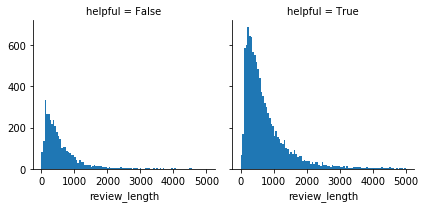

In [23]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=100)

#### Star rating

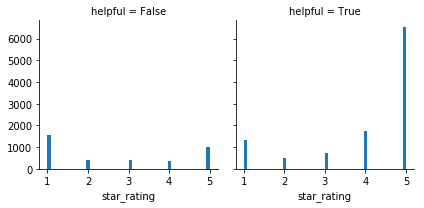

In [6]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

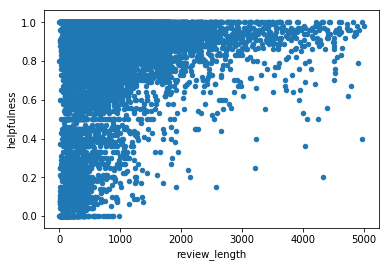

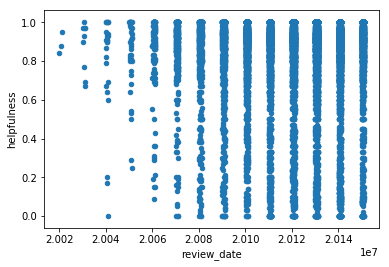

In [24]:
df.plot.scatter(x='review_length',y='helpfulness')
df['review_date'] = pd.to_datetime(df["review_date"]).dt.strftime("%Y%m%d").astype(int)
df.plot.scatter(x='review_date',y='helpfulness')

#### Verified purchase

In [7]:
ver = df[df.verified_purchase == 'Y']
not_ver = df[df.verified_purchase == 'N']

print("avg helpfulness of verified purchases: {0}".format(ver.helpfulness.mean()))
print("avg helpfulness of unverified purchases: {0}".format(not_ver.helpfulness.mean()))

avg helpfulness of verified purchases: 0.8414531317494457
avg helpfulness of unverified purchases: 0.8017437961100016


# Predicting using Naive Bayes

In [8]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english') and len(word) > 3]

In [9]:
X = df['review_body']
Y = df['helpful']

In [10]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [11]:
X = bow_transformer.transform(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [13]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 277  804]
 [ 247 3040]]


              precision    recall  f1-score   support

       False       0.53      0.26      0.35      1081
        True       0.79      0.92      0.85      3287

   micro avg       0.76      0.76      0.76      4368
   macro avg       0.66      0.59      0.60      4368
weighted avg       0.73      0.76      0.73      4368



#### ComplementNB 

In [15]:
cnb = ComplementNB()
cnb.fit(X_train, Y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [16]:
preds = cnb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[ 333  748]
 [ 334 2953]]


              precision    recall  f1-score   support

       False       0.50      0.31      0.38      1081
        True       0.80      0.90      0.85      3287

   micro avg       0.75      0.75      0.75      4368
   macro avg       0.65      0.60      0.61      4368
weighted avg       0.72      0.75      0.73      4368



#### Manual examination

In [17]:
df[df.helpfulness > 0.1].sort_values('helpfulness').head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
413,24680098,2,Automotive,B0042KMX18,waste money go to local store to get normal qu...,2014-08-02,R3B38SVMSMAA42,1,19,Y,0.11,False,358


In [18]:
mid_review = df['review_body'][2808]
mid_review_transformed = bow_transformer.transform([mid_review])
print("predicted helpful: {0}, actual helpfulness: {1}".format(nb.predict(mid_review_transformed)[0],df['helpfulness'][2808]))

predicted helpful: True, actual helpfulness: 1.0


#### Popular products

In [19]:
df.product_id.value_counts(ascending=False).head(6)

B009PMO208    59
B00005RHQQ    56
B00S5R56B8    34
B001OBKPUE    30
B009UZ1TE2    28
B002Q1INDM    27
Name: product_id, dtype: int64

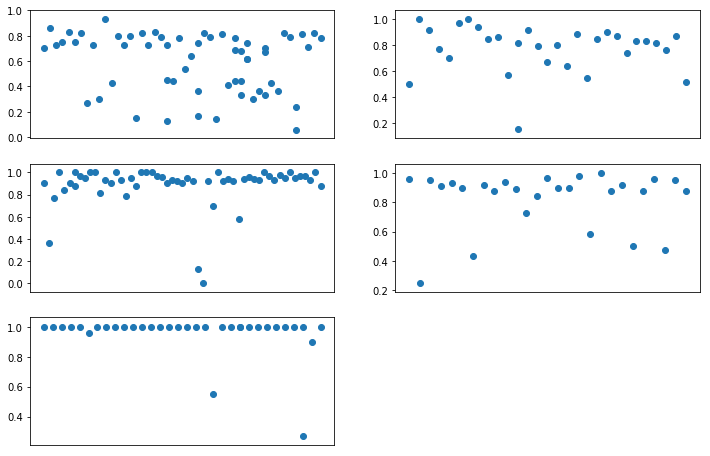

In [21]:
df_1 = df[df.product_id == 'B009PMO208']
df_2 = df[df.product_id == 'B00005RHQQ']
df_3 = df[df.product_id == 'B00S5R56B8']
df_4 = df[df.product_id == 'B001OBKPUE']
df_5 = df[df.product_id == 'B009UZ1TE2']
df_6 = df[df.product_id == 'B002Q1INDM']

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (2, 0))
ax4 = plt.subplot2grid(gridsize, (0, 1))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 1))

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_xticks([])

sctr = ax1.scatter(x = df_1.review_date, y = df_1.helpfulness)
sctr = ax2.scatter(x = df_2.review_date, y = df_2.helpfulness)
sctr = ax3.scatter(x = df_3.review_date, y = df_3.helpfulness)
sctr = ax4.scatter(x = df_4.review_date, y = df_4.helpfulness)
sctr = ax5.scatter(x = df_5.review_date, y = df_5.helpfulness)
sctr = ax6.scatter(x = df_6.review_date, y = df_6.helpfulness)